In [1]:
# To support both python 2 and python 3
from __future__ import division, print_function, unicode_literals

import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "classification"

def save_fig(fig_id, tight_layout=True):
    image_path = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
    if not os.path.exists(image_path):
        os.makedirs(image_path)
    path = os.path.join(image_path, fig_id + ".png")
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format='png', dpi=300)

# MNIST
**Warning**: fetch_mldata() is deprecated since Scikit-Learn 0.20. You should use fetch_openml() instead. However, it returns the unsorted MNIST dataset, whereas fetch_mldata() returned the dataset sorted by target (the training set and the test test were sorted separately). In general, this is fine, but if you want to get the exact same results as before, you need to sort the dataset using the following function:

In [2]:
def sort_by_target(mnist):
    reorder_train = np.array(sorted([(target, i) for i, target in enumerate(mnist.target[:60000])]))[:, 1]
    reorder_test = np.array(sorted([(target, i) for i, target in enumerate(mnist.target[60000:])]))[:, 1]
    mnist.data[:60000] = mnist.data[reorder_train]
    mnist.target[:60000] = mnist.target[reorder_train]
    mnist.data[60000:] = mnist.data[reorder_test + 60000]
    mnist.target[60000:] = mnist.target[reorder_test + 60000]
    

In [3]:
try:
    from sklearn.datasets import fetch_openml
    mnist = fetch_openml('mnist_784', version=1, cache=True)
    mnist.target = mnist.target.astype(np.int8)
    sort_by_target(mnist)
except ImportError:
    from sklearn.datasets import fetch_mldata
    mnist = fetch_mldata('MNIST original')
mnist["data"], mnist["target"]
    

(array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]], dtype=uint8),
 array([0., 0., 0., ..., 9., 9., 9.]))

In [4]:
X, y = mnist["data"], mnist["target"]
print(X.shape, y.shape)

(70000, 784) (70000,)


In [5]:
28 * 28

784

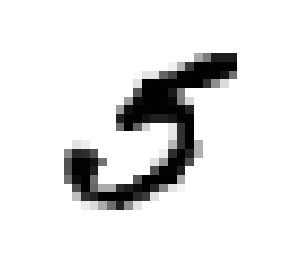

In [6]:
some_digit = X[36000]
some_digit_image = some_digit.reshape(28, 28)
plt.imshow(some_digit_image, cmap=mpl.cm.binary,
          interpolation="nearest")
plt.axis("off")
save_fig("some_digit_plot")
plt.show()

In [7]:
def plot_digit(data):
    image = data.reshape(28, 28)
    plt.imshow(image, cmap=mpl.cm.binary,
              interpolation="nearest")
    plt.axis("off")

In [8]:
# EXTRA
def plot_digits(instances, images_per_row=10, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    images = [instance.reshape(size, size) for instance in instances]
    n_rows = (len(instances) - 1) // images_per_row + 1
    row_images = []
    n_empty = n_rows * images_per_row - len(instances)
    images.append(np.zeros((size, size * n_empty)))
    for row in range(n_rows):
        rimages = images[row * images_per_row : (row + 1) * images_per_row]
        row_images.append(np.concatenate(rimages, axis=1))
    image = np.concatenate(row_images, axis=0)
    plt.imshow(image, cmap=mpl.cm.binary, **options)
    plt.axis("off")

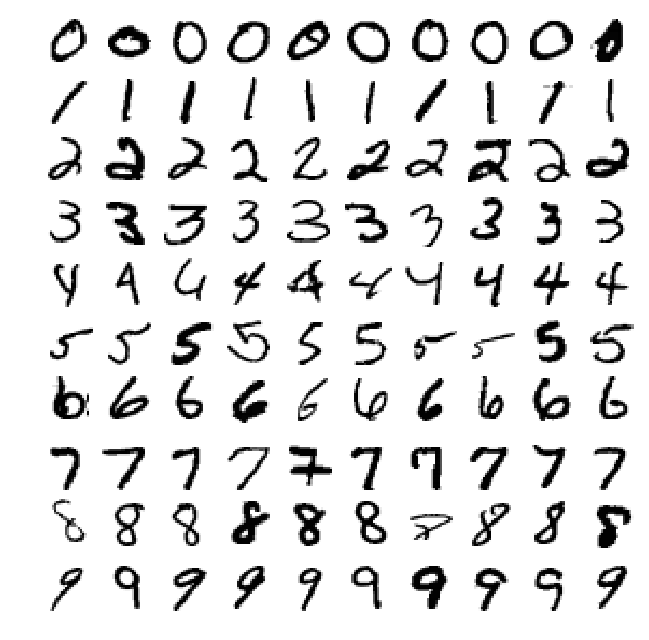

In [9]:
plt.figure(figsize=(9, 9))
example_images = np.r_[X[:12000:600], X[13000:30600:600], X[30600:60000:590]]
plot_digits(example_images, images_per_row=10)
save_fig("more_digits_plot")
plt.show()

In [10]:
y[36000]

5.0

In [11]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

import numpy as np
shuffle_index = np.random.permutation(60000)
X_train, y_train = X_train[shuffle_index], y_train[shuffle_index]

# Binary classifier

In [12]:
y_train_5 = (y_train == 5)
y_test_5 = (y_test == 5)

In [13]:
from sklearn.linear_model import SGDClassifier
sgd_clf = SGDClassifier(max_iter=5, tol=np.infty, random_state=42)
sgd_clf.fit(X_train, y_train_5)
print(sgd_clf.predict([some_digit]))
from sklearn.model_selection import cross_val_score
print(cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring="accuracy"))

[ True]
[0.96265 0.96285 0.9616 ]


In [14]:
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

skfolds = StratifiedKFold(n_splits=3, random_state=42)
for train_index, test_index in skfolds.split(X_train, y_train_5):
    clone_clf = clone(sgd_clf)
    X_train_folds = X_train[train_index]
    y_train_folds = (y_train_5[train_index])
    X_test_fold = X_train[test_index]
    y_test_fold = (y_train_5[test_index])
    
    clone_clf.fit(X_train_folds, y_train_folds)
    y_pred = clone_clf.predict(X_test_fold)
    n_correct = sum(y_pred == y_test_fold)
    print(n_correct / len(y_pred))

0.96265
0.96285
0.9616


## 使用混淆矩阵进行评估

In [23]:
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix
y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)
print(confusion_matrix(y_train_5, y_train_pred))

# 准确率与召回率
from sklearn.metrics import precision_score, recall_score, f1_score
print("precision:", precision_score(y_train_5, y_train_pred))
print("recall:", recall_score(y_train_5, y_train_pred))
print("f1-score:", f1_score(y_train_5, y_train_pred))

[[53865   714]
 [ 1544  3877]]
precision: 0.8444783271618383
recall: 0.7151817007932116
f1-score: 0.7744706352377149


## 决策函数

In [24]:
sgd_clf.decision_function([some_digit])

array([90538.62624647])

In [25]:
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3, 
                            method="decision_function")

In [26]:
y_scores.shape

(60000,)

In [28]:
# hack to work around issue #9589 in Scikit-Learn 0.19.0
if y_scores.ndim == 2:
    y_scores = y_scores[:, 1]
y_scores.shape

(60000,)

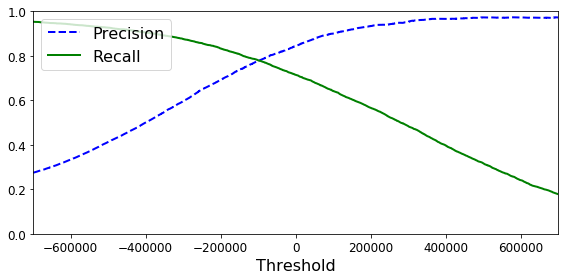

In [31]:
from sklearn.metrics import precision_recall_curve
precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision", linewidth=2)
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall", linewidth=2)
    plt.xlabel("Threshold", fontsize=16)
    plt.legend(loc="upper left", fontsize=16)
    plt.ylim([0, 1])

plt.figure(figsize=(8, 4))
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.xlim([-700000, 700000])
save_fig("precision_recall_vs_threshold_plot")
plt.show()


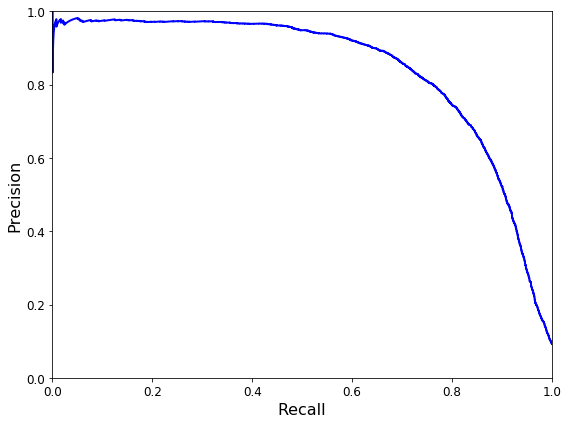

In [32]:
def plot_precision_vs_recall(precisions, recalls):
    plt.plot(recalls, precisions, "b-", linewidth=2)
    plt.xlabel("Recall", fontsize=16)
    plt.ylabel("Precision", fontsize=16)
    plt.axis([0, 1, 0, 1])

plt.figure(figsize=(8, 6))
plot_precision_vs_recall(precisions, recalls)
save_fig("precision_vs_recall_plot")
plt.show()